<a href="https://colab.research.google.com/github/Sanchitmiok/WineQualityPrediction/blob/main/WineQuality(XGb).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality Prediction Project:

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install xgboost

In [ ]:
!pip install lightgbm

In [ ]:
import warnings
warnings.simplefilter("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Importing all the dependencies

In [ ]:
df = pd.read_csv("/content/winequality-red.csv")

Instead of downloading the entire dataset on my local computer I am simply loading the file directly from the GitHub repository link using the raw option.

In [ ]:
df # Taking a look at the dataset's first and last 5 rows showcasing all the column names as well

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


So by taking a look at the above data frame I can see that the column quality is the target label making the remaining columns as the features that we can customize and use to predict our label. This classifies to be a Classification problem!

# Exploratory Data Analysis (EDA)

In [ ]:
df.shape

(1599, 12)

I see that there are total 1599 rows and 12 columns present in our dataset.

In [ ]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


Luckily we do not see any missing values in any of the columns of our dataset so we don't have to worry about handling missing data.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Great none of the columns have any object data type values and our label is the only integer value making all the feature columns as float datatype i.e. similar datatype.

In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Using the describe method I can see the count, mean, standard deviation, minimum, maximum and inter quantile values of our dataset.

As per my observation:
1. There is a big gap between 75% and max values of residual sugar column
2. There is a big gap between 75% and max values of free sulfur dioxide	column
3. There is a huge gap between 75% and max value of total sulfur dioxide column

All these gaps indicate that there are outliers present in our dataset which might need to be treated so as to get a better model accuracy later.

In [ ]:
df.skew() # acceptable range is +/-0.5

,0
fixed acidity,0.982751
volatile acidity,0.671593
citric acid,0.318337
residual sugar,4.540655
chlorides,5.680347
free sulfur dioxide,1.250567
total sulfur dioxide,1.515531
density,0.071288
pH,0.193683
sulphates,2.428672


Here we see the skewness information present in our dataset. We will ignore quality since it is our target label in the dataset. Now taking a look at all the feature columns we see that fixed acidity, volatile acidity, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, sulphates and alcohol are all outside the acceptable range of +/-0.5. This skewness indicates outliers being present in our dataset that will need to be treated if required.

# Visualization

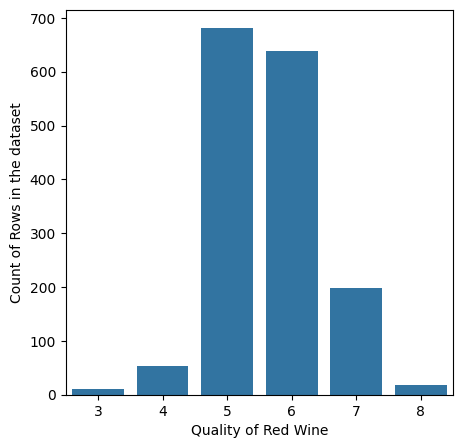

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x ='quality', data = df)
plt.xlabel('Quality of Red Wine')
plt.ylabel('Count of Rows in the dataset')
plt.show()

In the countplot representation we see the various categories of red wine quality and it shows that the number of data present for quality score 5 and 6 is way higher than it's counterparts. This indicates an imbalance which will need to be rectified so that our machine learning model do not get biased to a certain value during prediction.

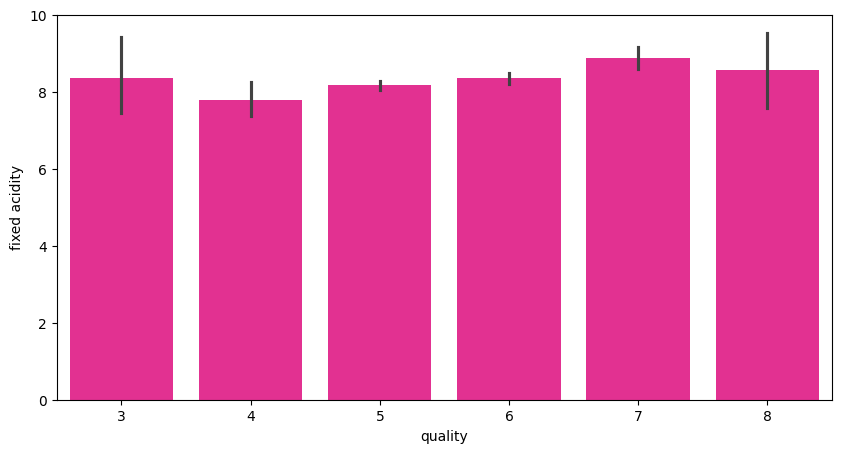

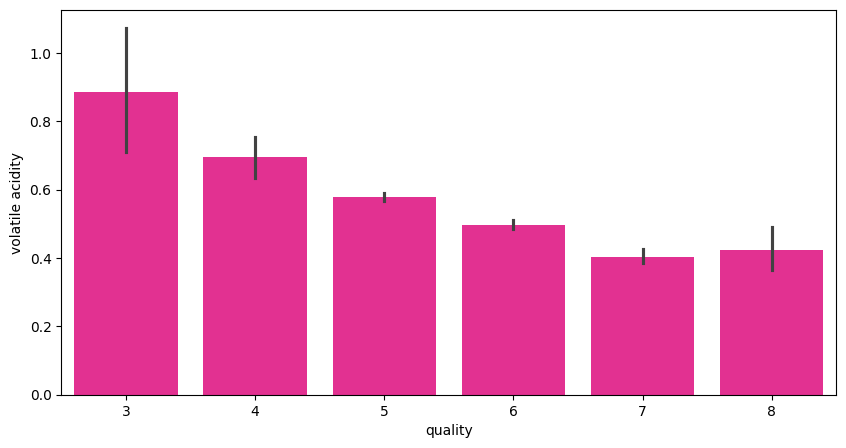

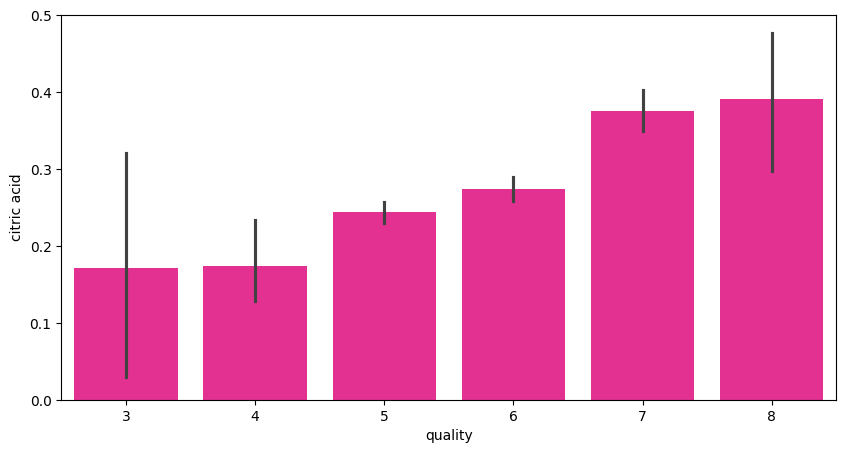

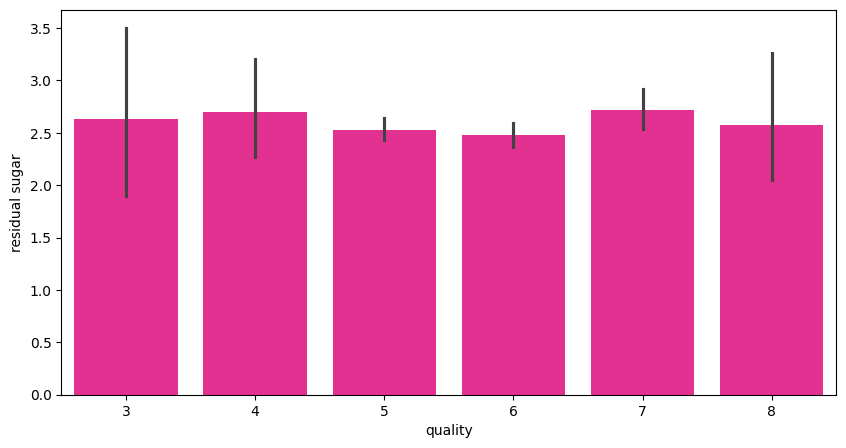

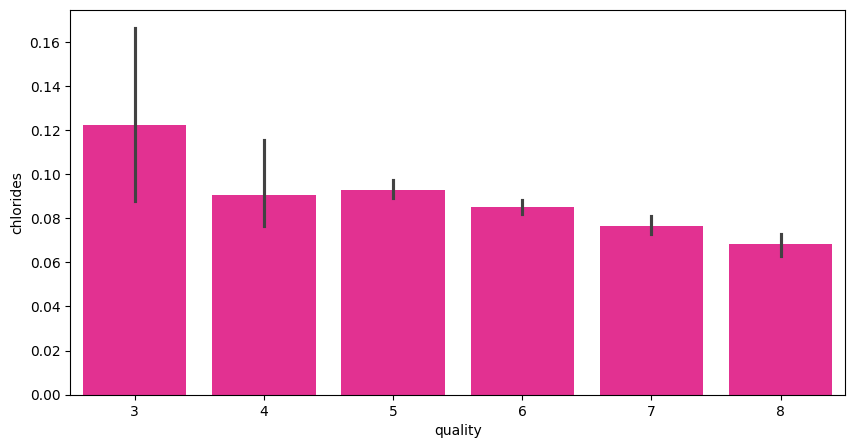

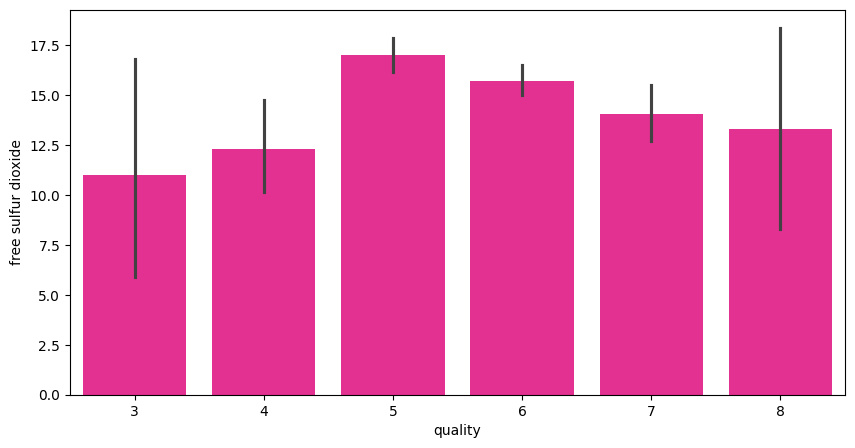

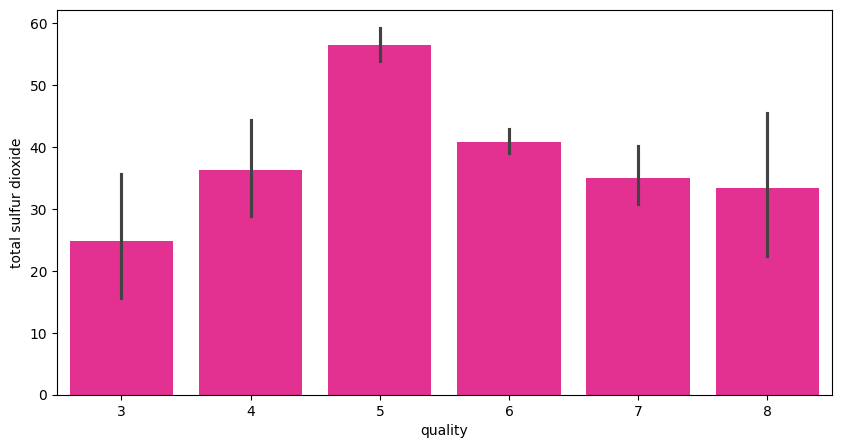

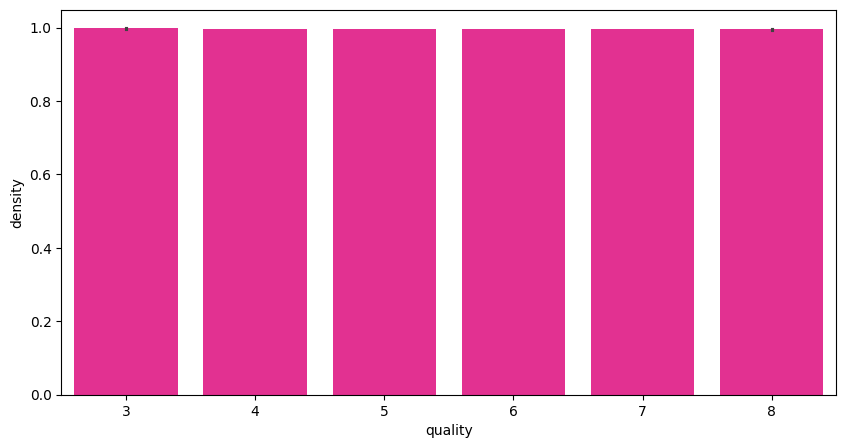

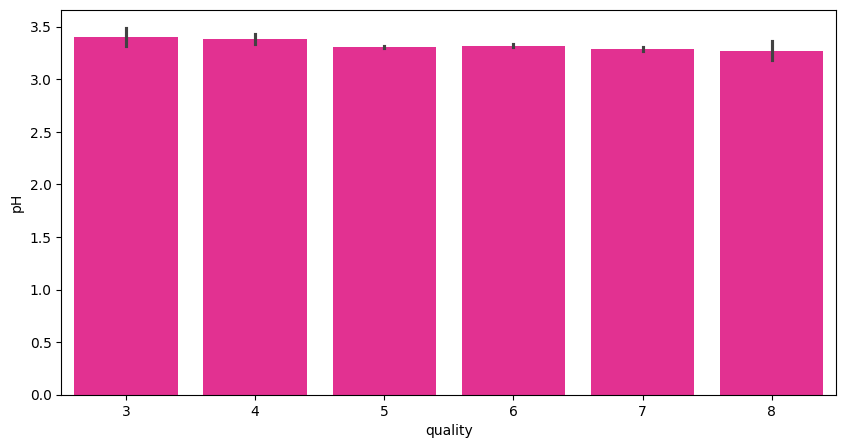

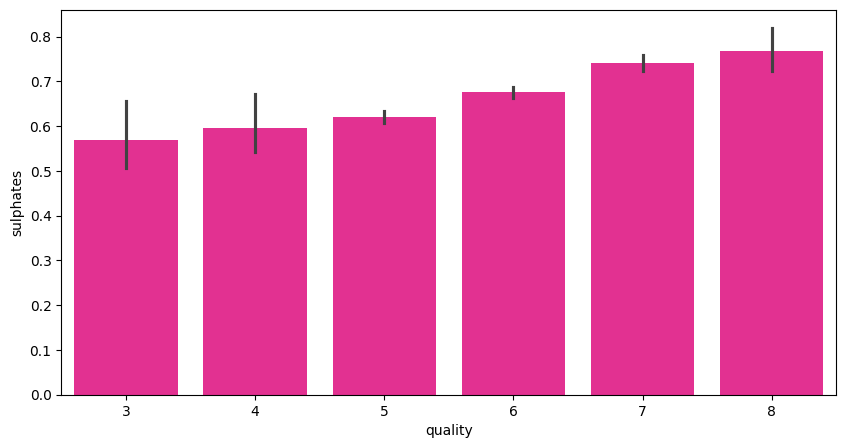

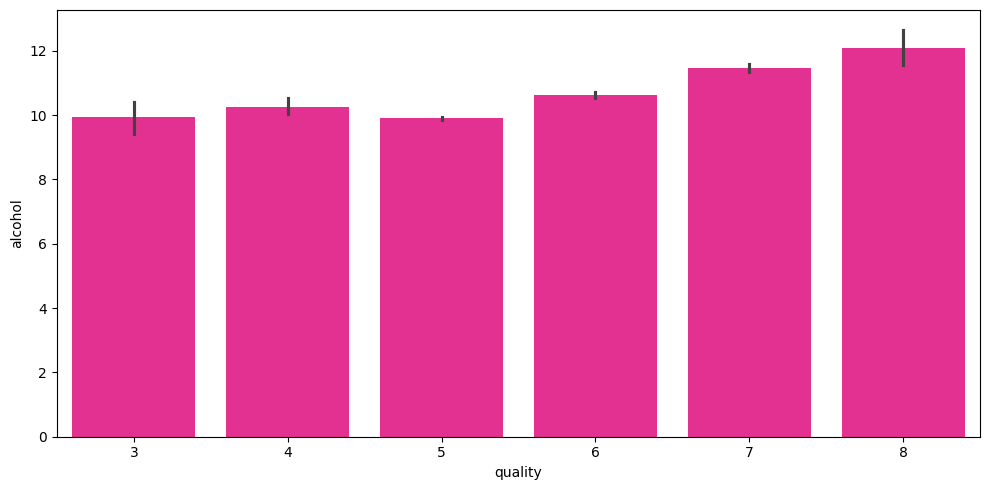

In [ ]:
index=0
labels = df['quality']
features = df.drop('quality', axis=1)

for col in features.items():
    plt.figure(figsize=(10,5))
    sns.barplot(x=labels, y=col[index], data=df, color="deeppink")
plt.tight_layout()
plt.show()

With the feature vs label barplot we are able to see the trend corresponding to the impact each has with respect to predicting the quality column (our target variable).

Observations regarding feature compared to the label are:
01. fixed acidity vs quality - no fixed pattern
02. volatile acidity vs quality - there is a decreasing trend
03. citric acid vs quality - there is an increasing trend
04. residual sugar vs quality - no fixed pattern
05. chlorides vs quality - there is a decreasing trend
06. free sulfur dioxide vs quality - no fixed pattern as it is increasing then decreasing
07. total sulfur dioxide vs quality - no fixed pattern as it is increasing then decreasing
08. density vs quality - no pattern at all
09. pH vs quality - no pattern at all
10. sulphates vs quality - there is an increasing trend
11. alcohol vs quality - there is an increasing trend

So here we can conclude that to get better quality wine citric acid, sulphates and alcohol columns play a major role.

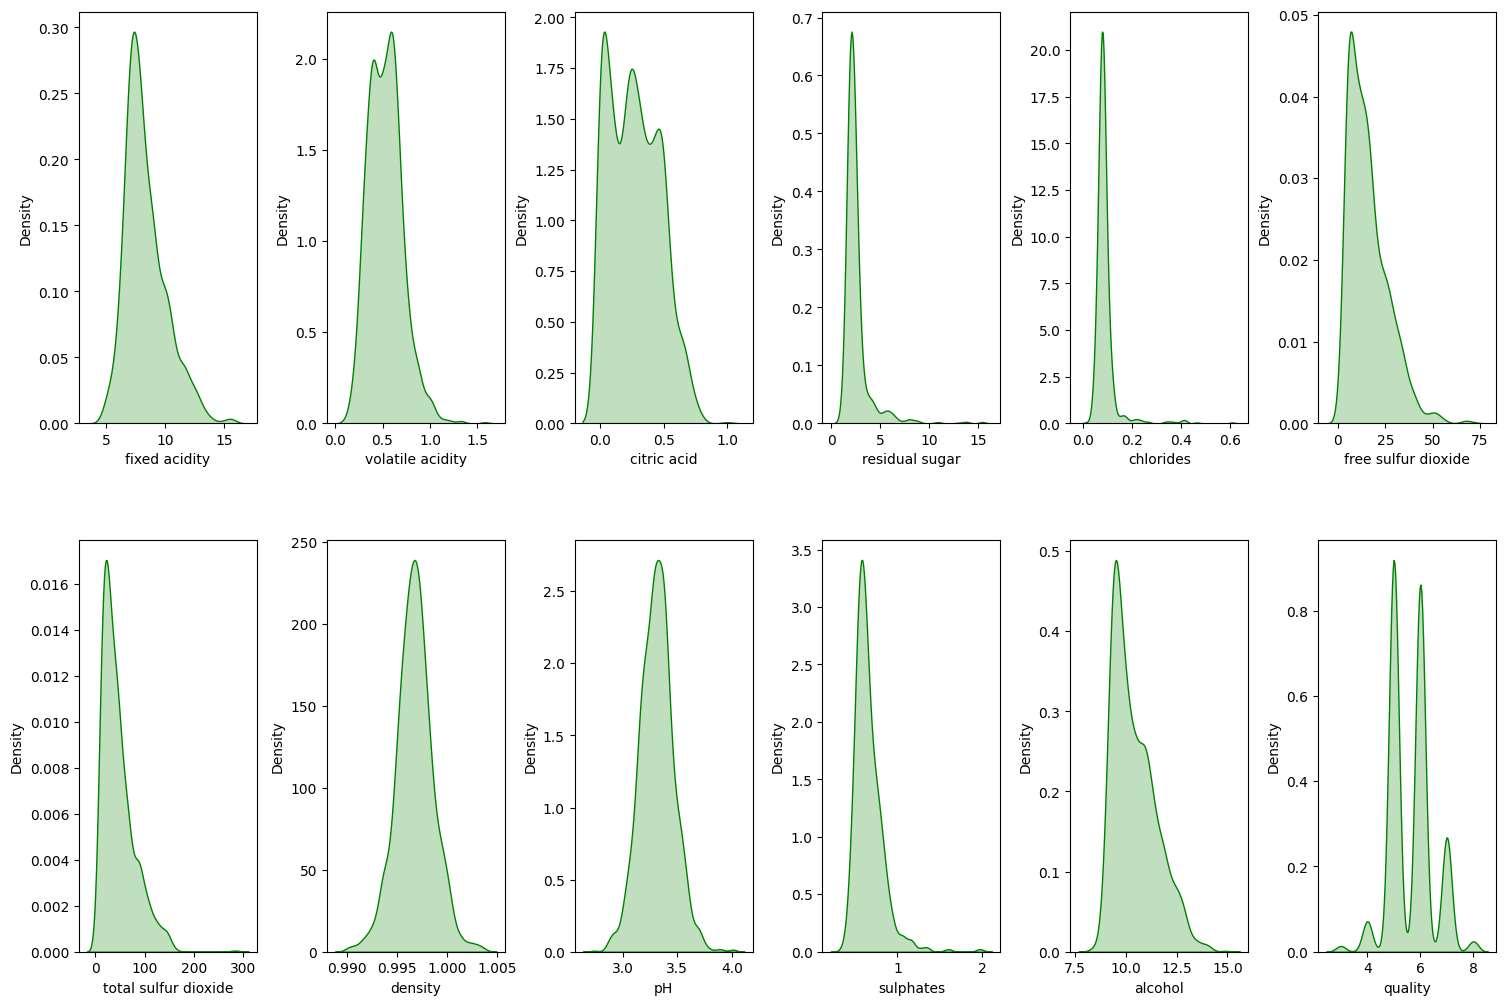

In [ ]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(15,10))
index = 0
ax = ax.flatten()
for col, value in df.items():
    sns.distplot(value, ax=ax[index], hist=False, color="g", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

The distribution plots show that few of the columns are in normal distribution category showing a proper bell shape curve. However, we do see skewness in most of the feature columns like citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, sulphates and alcohol columns. We are going to ignore the label column since it is a categorical column and will need to fix the imbalance data inside it.

With respect to the treatment of skewness and outliers I will perform the removal or treatment after I can see the accuracy dependency of the machine learning models.

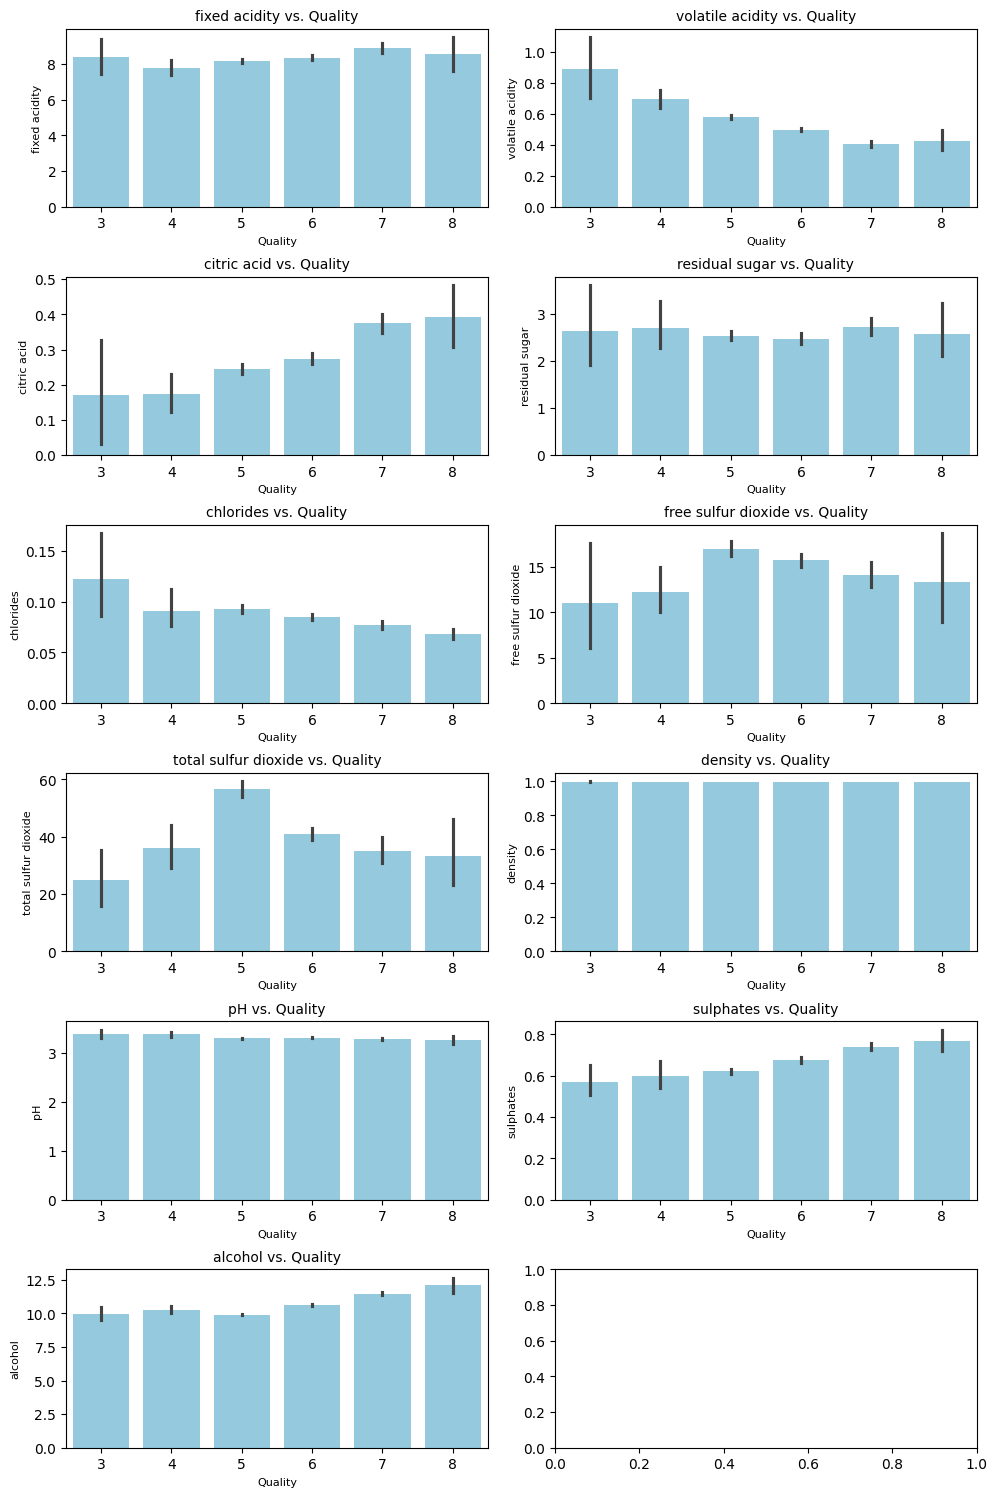

In [ ]:

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
            'pH', 'sulphates', 'alcohol']
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 15))
axes = axes.flatten()

# Iterate and create barplots
for i, feature in enumerate(features):
    sns.barplot(x='quality', y=feature, data=df, ax=axes[i], color="skyblue")
    axes[i].set_title(f'{feature} vs. Quality', fontsize=10)
    axes[i].set_xlabel('Quality', fontsize=8)
    axes[i].set_ylabel(feature, fontsize=8)

# Adjust layout and show the plot
plt.tight_layout(pad=0.8)
plt.show()

Here i have try to show that how these properties influences quality


# Correlation using a Heatmap

1. Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.

2. Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

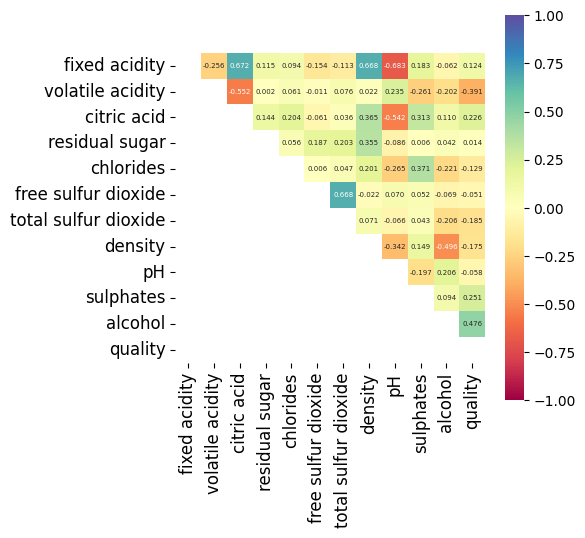

In [ ]:
lower_triangle = np.tril(df.corr())
plt.figure(figsize=(5,5))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f',
            annot_kws={'size':5}, cmap="Spectral", mask=lower_triangle)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

I see that the above heatmap shows the correlation matrix data wherein there are positive as well as negative correlations between the target label and other feture columns. A zero correlation indicates that there is no relationship between the variables. Looking at the above representation I see that quality column is positively correlated with alcohol and it is negatively correlated with the volatile acidity. The quality column is least correlated with residual sugar showing a coefficient value of 0.014 that close to 0. Similarly we can bifurcate all the other positively and negatively correlated feature columns with respect to the target label.

Also there are some highly positive and negative correlated feature columns that can pose the concern for multicollinearity. If the correlation coefficient, assuming it to be the variable 'r', is exactly +1 or -1, then it is called perfect multicollinearity. But even if this 'r' is close to -1 or +1 then one of the features should be removed from the model if at all possible.

Right now I see columns fixed acidity and citirc acid are positively correlated with a value of 0.672 which is close to 1. Similary, columns fixed acidity and density are positively correlated with a value of 0.668 again being close to 1. The other 2 column that's positively correlated are free sulfur dioxide and total sulfur dioxide with a value of 0.668 which is close to the value 1. The only negatively correlated columns that pop up are fixed acitidy and pH with a value -0.683 being close to the value -1.

We may need to deal with multicollinearity later if required to improve the accuracy of our machine learning models.

# Outlier removal

In [ ]:
df.shape

(1451, 12)

Confirming the number of columns and rows before removing the outliers from the dataset.

In [ ]:
# Z score method

z=np.abs(zscore(df))
threshold=3
np.where(z>3)

df=df[(z<3).all(axis=1)]
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


I have used the Z score method to get rid of outliers present in our dataset that are not in the acceptable range of +/-0.5 value of skewness.

In [ ]:
df.shape

(1451, 12)

Checking the number of rows present in the dataset after applying the outlier removal technique.

In [ ]:
# Percentage of Data Loss

data_loss=(1599-1464)/1599*100
# 1599 (number of rows in the original dataframe) and 1464 (number of rows after outlier removal)
data_loss

8.442776735459661

After removing the outliers we are checking the data loss percentage by comparing the rows in our original data set and the new data set post removal of the outliers.

# Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label

In [ ]:
X = df.drop('quality', axis=1)
Y = df['quality']

I have bifurcated the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

### Taking care of class imbalance

In [ ]:
Y.value_counts()

,count
quality,
5,617
6,586
7,185
4,47
8,16


Listing the values of our label column to count the number of rows occupied by each category. This indicates class imbalance that we will need to fix by using the oversampling method.

In [ ]:
# adding samples to make all the categorical quality values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

SMOTE is the over sampling mechanism that we are using to ensure that all the categories present in our target label have the same value.

In [ ]:
Y.value_counts()

,count
quality,
5,617
6,617
7,617
4,617
8,617


After applying over sampling we are one again listing the values of our label column to cross verify the updated information. Here we see that we have successfully resolved the class imbalance problem and now all the categories have same data ensuring that the machine learning model does not get biased towards one category.

In [ ]:
Y # Displaying just the label

,quality
0,5
1,5
2,5
3,6
4,5
...,...
3080,8
3081,8
3082,8
3083,8


### Label Binarization

In [ ]:
Y = Y.apply(lambda y_value:1 if y_value>=7 else 0) # 1 is for good quality and 0 for bad (not good) quality
Y # Displaying the label after applying label binarization

,quality
0,0
1,0
2,0
3,0
4,0
...,...
3080,1
3081,1
3082,1
3083,1


Using the label binarization technique we have tagged the categories present in our target label to 2 major class that are 0 for bad quality wine and 1 for good quality wine.

In [ ]:
X # Displaying all the features except the label

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000
1,7.800000,0.880000,0.000000,2.600000,0.098000,25.000000,67.000000,0.996800,3.200000,0.680000,9.800000
2,7.800000,0.760000,0.040000,2.300000,0.092000,15.000000,54.000000,0.997000,3.260000,0.650000,9.800000
3,11.200000,0.280000,0.560000,1.900000,0.075000,17.000000,60.000000,0.998000,3.160000,0.580000,9.800000
4,7.400000,0.700000,0.000000,1.900000,0.076000,11.000000,34.000000,0.997800,3.510000,0.560000,9.400000
...,...,...,...,...,...,...,...,...,...,...,...
3080,7.799516,0.344634,0.336878,1.815366,0.075383,20.841497,31.682993,0.994239,3.200048,0.689244,11.461464
3081,10.527336,0.337050,0.495467,4.240311,0.071295,5.000000,14.705017,0.997373,3.184533,0.723382,11.690657
3082,9.259599,0.395013,0.502992,1.879800,0.070900,6.800501,16.000000,0.994877,3.204015,0.686010,12.350376
3083,9.852915,0.376280,0.586221,3.372103,0.081430,6.000000,17.476752,0.996972,3.166686,0.865174,12.105239


### Feature Scaling

In [ ]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X # Displaying all the features after applying scaling technique to avoid bias output

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.670410,1.061447,-1.502291,-0.628487,-0.129004,-0.255050,-0.083245,0.843114,1.502953,-0.793859,-1.261758
1,-0.414943,2.083227,-1.502291,0.155469,1.092538,1.298412,1.172109,0.236899,-0.763266,0.108641,-0.900438
2,-0.414943,1.402041,-1.296475,-0.180512,0.759390,0.188797,0.677575,0.358142,-0.324643,-0.116984,-0.900438
3,1.756529,-1.322706,1.379136,-0.628487,-0.184529,0.410720,0.905822,0.964356,-1.055682,-0.643443,-0.900438
4,-0.670410,1.061447,-1.502291,-0.628487,-0.129004,-0.255050,-0.083245,0.843114,1.502953,-0.793859,-1.261758
...,...,...,...,...,...,...,...,...,...,...,...
3080,-0.415252,-0.955808,0.231084,-0.723272,-0.163266,0.836978,-0.171387,-1.315514,-0.762912,0.178162,0.600363
3081,1.326919,-0.998858,1.047088,1.992516,-0.390248,-0.920819,-0.817246,0.584056,-0.876337,0.434912,0.807394
3082,0.517257,-0.669831,1.085809,-0.651110,-0.412166,-0.721033,-0.767984,-0.928638,-0.733915,0.153841,1.403317
3083,0.896188,-0.776166,1.514055,1.020176,0.172509,-0.809858,-0.711807,0.341230,-1.006802,1.501300,1.181886


Even though all our feature columns were of float data type I was unhappy with the decimal place differences and was worried that it might make my model biased. Therefore I am using the Standard Scaler method to ensure all my feature columns have been standardized.

# Creating the training and testing data sets

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

I am taking 20 percent of the complete dataset for training purpose and the remaing 80 percent with be used to train the machine learning models

# Machine Learning Model for Classification and Evaluation Metrics

In [ ]:
results={}

In [ ]:
# Classification Model Function

def classify(classifier,model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21)

    # Training the model
    model.fit(X_train, Y_train)

    # Predicting Y_test
    pred = model.predict(X_test)

    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)

    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)

    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)

    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

    results.update({classifier:acc_score})

I have defined a class that will perform the train-test split, training of machine learning model, predicting the label value, getting the accuracy score, generating the classification report, getting the cross validation score and the result of difference between the accuracy score and cross validation score for any machine learning model that calls for this function.

In [ ]:
# Logistic Regression
model=LogisticRegression()
classify("LR",model, X, Y)

Accuracy Score: 88.49270664505673

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90       375
           1       0.83      0.88      0.86       242

    accuracy                           0.88       617
   macro avg       0.88      0.88      0.88       617
weighted avg       0.89      0.88      0.89       617

Cross Validation Score: 87.26094003241491

Accuracy Score - Cross Validation Score is 1.2317666126418203


Created the Logistic Regression Model and checked for it's evaluation metrics.

In [ ]:
# Support Vector Classifier

model=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify("SVC",model, X, Y)

Accuracy Score: 91.73419773095624

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       375
           1       0.88      0.91      0.90       242

    accuracy                           0.92       617
   macro avg       0.91      0.92      0.91       617
weighted avg       0.92      0.92      0.92       617

Cross Validation Score: 90.14586709886547

Accuracy Score - Cross Validation Score is 1.5883306320907735


Created the Support Vector Classifier Model and checked for it's evaluation metrics.

In [ ]:
# Random Forest Classifier

model=RandomForestClassifier(max_depth=15, random_state=111)
classify("RF",model, X, Y)

Accuracy Score: 95.46191247974069

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       375
           1       0.91      0.98      0.94       242

    accuracy                           0.95       617
   macro avg       0.95      0.96      0.95       617
weighted avg       0.96      0.95      0.95       617

Cross Validation Score: 92.86871961102105

Accuracy Score - Cross Validation Score is 2.5931928687196404


Created the Random Forest Classifier Model and checked for it's evaluation metrics.

In [ ]:
# XGB Classifier
model=xgb.XGBClassifier(verbosity=0)
classify("XGB",model, X, Y)

Accuracy Score: 96.75850891410049

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       375
           1       0.93      0.99      0.96       242

    accuracy                           0.97       617
   macro avg       0.96      0.97      0.97       617
weighted avg       0.97      0.97      0.97       617

Cross Validation Score: 92.38249594813614

Accuracy Score - Cross Validation Score is 4.37601296596435


Created the XGB Classifier Model and checked for it's evaluation metrics.

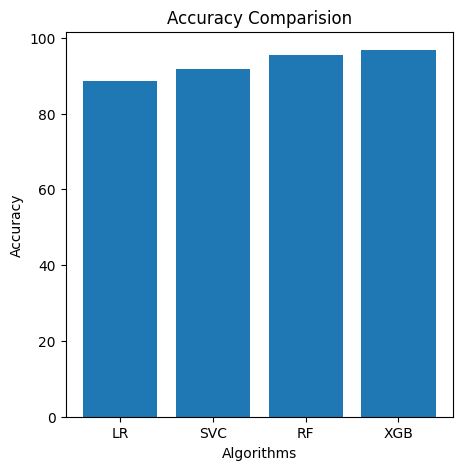

In [ ]:
import matplotlib.pyplot as plt

# Extracting keys and values
keys = list(results.keys())
values = list(results.values())

plt.figure(figsize=(5,5))
# Creating the bar chart
plt.bar(keys, values)

# Adding title and labels
plt.title('Accuracy Comparision')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

# Prediction Function

In [ ]:
def predict_wine_quality(chemical_parameters):
    feature_names = ['fixed acidity', 'volatile acidity', 'citric acid',
                     'residual sugar', 'chlorides', 'free sulfur dioxide',
                     'total sulfur dioxide', 'density', 'pH', 'sulphates',
                     'alcohol']
    input_df = pd.DataFrame([chemical_parameters], columns=feature_names)

    # Scale the input data using the same scaler
    scaled_input = scaler.transform(input_df)

    # Make the prediction using the best trained model
    prediction = model.predict(scaled_input)
    print(type(model))
    return prediction[0]

In [ ]:
sample_chemical_parameters = [7.4, 0.25, 0.36, 1.8, 0.065, 10.0, 20.0, 0.99500, 3.20, 0.70, 12.0] # good
# sample_chemical_parameters = [8.1, 0.56, 0.17, 2.5, 0.092, 18.0, 54.0, 0.99700, 3.26, 0.65, 9.5] #bad

predicted_quality = predict_wine_quality(sample_chemical_parameters)

if predicted_quality == 1:
    print("Predicted Wine Quality: Good")
else:
    print("Predicted Wine Quality: Bad")

<class 'xgboost.sklearn.XGBClassifier'>
Predicted Wine Quality: Good
